 ![Verne](https://www.vernegroup.com/wp-content/uploads/2020/07/LOGO-VERNE-TECHNOLOGY-GROUP-3.png)

# Carga de datos y revisión

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt


In [2]:
conn = sqlite3.connect('Tiendas24H.sqlite')
consulta="select c.CodCliente, FechaNacimiento, EstadoCivil, Sexo, IngresosAnuales, N.NivelAcademico, O.Ocupacion, case     when v.CodCliente is null then 0   else 1  end as 'EsCliente' from clientes c inner join NivelAcademico N    on c.NivelAcademico = N.Codigo     inner join Ocupacion O on c.Ocupacion = o.Codigo     left outer join VentasCAB v          on v.codcliente = C.codcliente where c.Codcliente <>'CONTADO'"

df = pd.read_sql_query(consulta,conn)

df.head()

,CodCliente,FechaNacimiento,EstadoCivil,Sexo,IngresosAnuales,NivelAcademico,Ocupacion,EsCliente
0,000020,1976-04-08,M,M,90000.0,Licenciatura,Profesional especializado,1
1,000026,1975-05-14,S,M,60000.0,Licenciatura,Profesional especializado,1
2,000026,1975-05-14,S,M,60000.0,Licenciatura,Profesional especializado,1
3,000026,1975-05-14,S,M,60000.0,Licenciatura,Profesional especializado,1
4,000026,1975-05-14,S,M,60000.0,Licenciatura,Profesional especializado,1


In [3]:
df.dropna(axis=0,inplace=True)

In [4]:
caracteristicas = ["EstadoCivil", "Sexo", "IngresosAnuales","NivelAcademico", "Ocupacion"]
etiqueta="EsCliente"

In [5]:
from sklearn.preprocessing import  LabelEncoder

le=LabelEncoder()
df['EstadoCivil'] = le.fit_transform(df['EstadoCivil'])
df['Sexo'] = le.fit_transform(df['Sexo'])

In [6]:
dum_df = pd.get_dummies(df[caracteristicas], columns=["NivelAcademico","Ocupacion"] )

In [7]:

X, y = dum_df, df[etiqueta]

# Balanceando con SMOTE

In [8]:
from imblearn.over_sampling import SMOTE 
from collections import Counter

In [9]:
print('Distribución Original %s' % Counter(y))
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print('Distribución balanceada %s' % Counter(y_res))

Distribución Original Counter({1: 10340, 0: 58})
Distribución balanceada Counter({1: 10340, 0: 10340})


In [10]:
from sklearn.model_selection import train_test_split
X_trainres, X_testres, y_trainres, y_testres = train_test_split(X_res, y_res, random_state=0)

# Clasificacion XGBoost

In [11]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc

from xgboost import XGBClassifier, plot_importance

In [12]:
xgb = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)
xgb.fit(X_trainres, y_trainres)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=33,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [13]:
xgb_predictions = xgb.predict(X_testres)

In [14]:
#!pip install pdpbox
from pdpbox import pdp, get_dataset, info_plots

In [15]:
def plot_pdp(model, df, feature, cluster_flag=False, nb_clusters=None, lines_flag=False):
    
    # Crear los datos que vamos a pintar
    pdp_goals = pdp.pdp_isolate(model=model, dataset=df, model_features=df.columns.tolist(), feature=feature)

    # plot it
    pdp.pdp_plot(pdp_goals, feature, cluster=cluster_flag, n_cluster_centers=nb_clusters, plot_lines=lines_flag)
    plt.show()

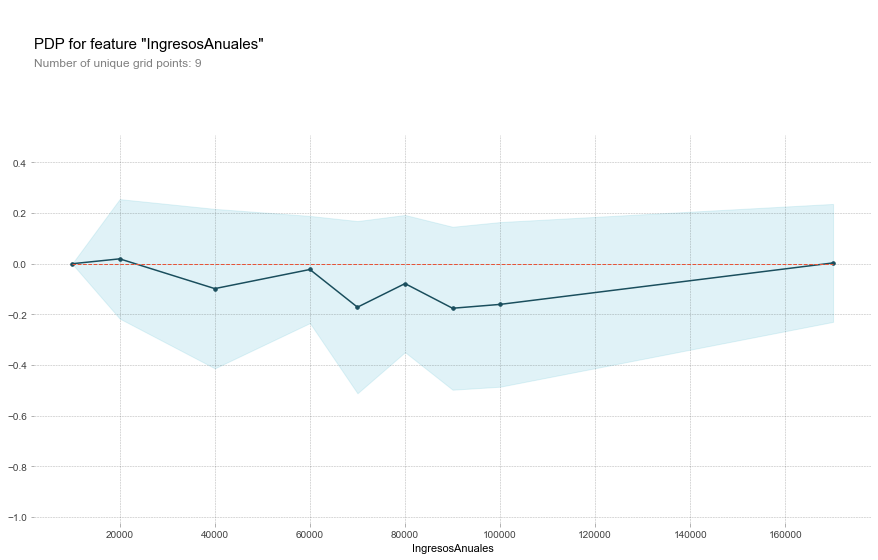

In [19]:
plot_pdp(xgb, X_trainres, 'IngresosAnuales')

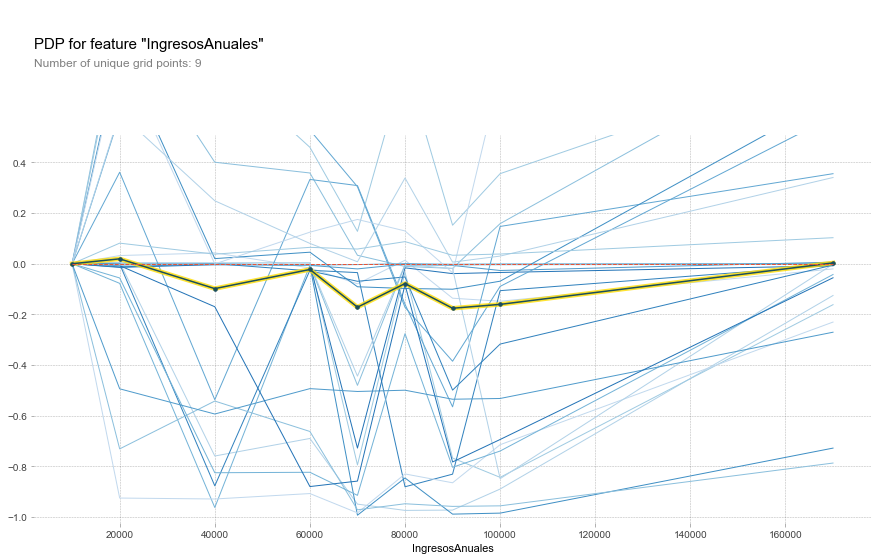

In [20]:
plot_pdp(xgb, X_trainres, 'IngresosAnuales', cluster_flag=True, nb_clusters=24, lines_flag=True)

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x217a2f2fbe0>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x217a35c1af0>})

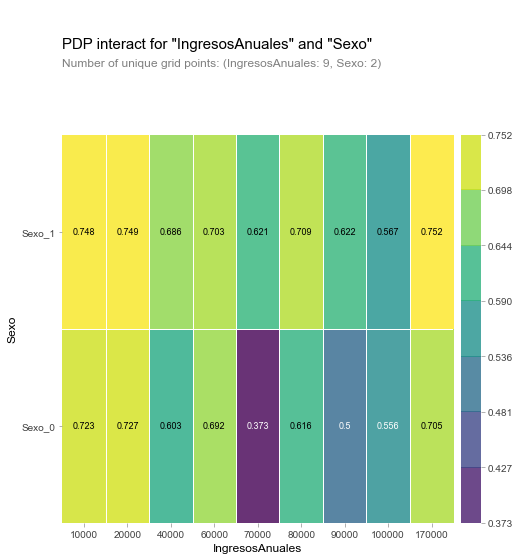

In [26]:
features_to_plot = ['IngresosAnuales', 'Sexo']
features_list = X_trainres.columns
inter1  =  pdp.pdp_interact(model=xgb, dataset=X_trainres, model_features=features_list, features=features_to_plot)
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='grid')